In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt


### Bitmap方法

In [2]:
with open('bitmap_canvas/canvas.json') as f:
    info = json.load(f)

with open('bitmap_canvas/region.npy', 'rb') as f:
    map_region = np.load(f, allow_pickle=True)

with open('bitmap_canvas/dist.npy', 'rb') as f:
    dist = np.load(f)


In [8]:
info

{'width': 1140,
 'height': 673,
 'regions': [{'points': [285.01171875,
    146.4279327392578,
    140.45083618164062,
    96.65760803222656],
   'alpha': 0.5},
  {'points': [408.193115234375,
    283.1513671875,
    43.216064453125,
    71.26980590820312],
   'alpha': 0.5},
  {'points': [492.36456298828125,
    122.07839965820312,
    193.51727294921875,
    340.95489501953125],
   'alpha': 0.8}],
 'insights': [[526.8411464650253, 321.47527599411114],
  [619.6543701473347, 408.01090473749537]]}

In [9]:
dist = dist.T
map_region = map_region.T

In [10]:
dist[1:101,1:101].shape

(100, 100)

In [11]:
def find_min_spiral(matrix, center):
    min_score = float('inf')
    min_pos = (0, 0)
    x = center[0] #current position; x
    y = center[1]; #current position; y
    d = 0; #urrent direction; 0=RIGHT, 1=DOWN, 2=LEFT, 3=UP
    c = 0; #counter
    s = 1; #chain size
    
    size = min(matrix.shape[0], matrix.shape[1])
 
    for k in range(1, size):
        for j in range(0, 2 if k<(size-1) else 3):
            for i in range(0, s):
                bbox = matrix[x-100:x+101,y-100:y+101]
                #print(x, y, bbox.shape)
                summ = sum(list(map(sum, bbox)))
                if summ < min_score and summ > 0 and (bbox.shape[0]> 199 and bbox.shape[1] > 199):
                    min_score = summ
                    min_pos = (x, y)
                c+=1
                if d==0: y = y + 1
                elif d==1: x = x + 1
                elif d==2: y = y - 1
                elif d==3: x = x - 1
            d = (d+1)%4
        s = s + 1;
    return min_score, min_pos

In [12]:
Cx, Cy = info['insights'][0]

In [13]:
sum(list(map(sum, dist[Cx-50:Cx+50, Cy-50:Cy+50])))

TypeError: slice indices must be integers or None or have an __index__ method

In [2]:
#min_score, min_pos = find_min_spiral(data, (Cx,Cy))

In [3]:
#min_score, min_pos, Cx, Cy

KeyError: 'center'

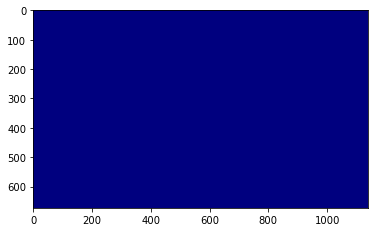

In [15]:
im = plt.imshow(dist, cmap='jet', interpolation='nearest')
plt.scatter(int(info['center'][0]), int(info['center'][1]), marker='^', c='yellow')
#plt.scatter(min_pos[0], min_pos[1], marker='x', c='r')
plt.colorbar(im);
plt.show()

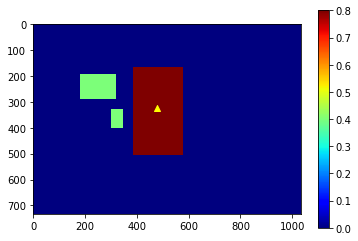

In [14]:
im = plt.imshow(region, cmap='jet', interpolation='nearest')
plt.scatter(int(info['center'][0]), int(info['center'][1]), marker='^', c='yellow')
plt.colorbar(im);
plt.show()

In [15]:
bit = np.zeros(region.shape)
for i in range(region.shape[0]):
    for j in range(region.shape[1]):
        if region[i][j] > 0:
            bit[i][j] = 1
        else:
            bit[i][j] = 0

In [16]:
overlap = np.zeros(bit.shape)
for i in range(100, bit.shape[0]-100):
    for j in range(100, bit.shape[1]-100):
        overlap[i,j] = sum(map(sum, bit[i-100:i+100,j-100:j+100]))/40000

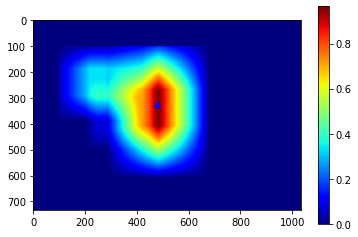

In [17]:
im = plt.imshow(overlap, cmap='jet', interpolation='nearest')
plt.scatter(int(info['center'][0]), int(info['center'][1]), marker='^', c='blue')
plt.colorbar(im);
plt.show()

In [18]:
Total_score = 0.5*dist+0.3*region+0.5*overlap
min_score = float('inf')
min_pos = (0, 0)
for i in range(Total_score.shape[0]):
    for j in range(Total_score.shape[1]):
        if Total_score[i][j] <= min_score:
            min_score = Total_score[i][j]
            min_pos = (i, j)
            #print(min_pos, min_score)

In [19]:
Total_score.shape, min_pos, min_score

((734, 1035), (325, 680), 0.14645373461784975)

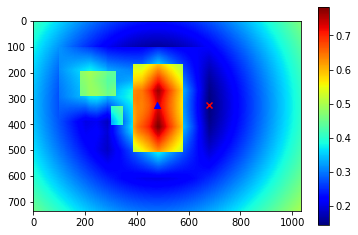

In [20]:
im = plt.imshow(Total_score, cmap='jet', interpolation='nearest')
plt.scatter(int(info['center'][0]), int(info['center'][1]), marker='^', c='blue')
plt.scatter(min_pos[1], min_pos[0], marker='x', c='r')
plt.colorbar(im);
plt.show()

### 向量方法

In [2]:
from shapely.geometry import Polygon
import seaborn as sns
from PIL import Image, ImageDraw 

In [3]:
def drawRegions(W, H, regions, alpha, POI, Place, scale_text):
    # creating new Image object 
    img = Image.new("RGBA", (W, H)) 
    
    # create rectangle image 
    img1 = ImageDraw.Draw(img)
    
    # draw region
    for i in range(0, len(regions)):
        shape = [(regions[i][0], regions[i][1]), (regions[i][0]+regions[i][2], regions[i][1]+regions[i][3])]
        opacity = int(255 * alpha[i])
        img1.rectangle(shape, fill = (39, 113, 149, opacity), outline = "#315669")
    
    # draw POI
    for p in range(0, len(POI)):
        r = 5
        leftUpPoint = (POI[p][0]-r, POI[p][1]-r)
        rightDownPoint = (POI[p][0]+r, POI[p][1]+r)
        img1.ellipse([leftUpPoint,rightDownPoint], fill = (255, 0, 0))
    
    # draw annoBox Center
    for p in range(0, len(Place)):
        r = 5
        leftUpPoint = (Place[p][0]-r, Place[p][1]-r)
        rightDownPoint = (Place[p][0]+r, Place[p][1]+r)
        img1.ellipse([leftUpPoint,rightDownPoint], fill = (0, 255, 0))
        
    img.save(scale_text+".PNG")
    #img.show()
    

In [4]:
def getIntersectArea(poly1, poly2):
    intersectPoint = poly1.intersects(poly2)
    if intersectPoint:
        return poly1.intersection(poly2).area
    else:
        return 0

In [5]:
def getDistance(p1, p2):
    return pow(pow(p2[0]-p1[0], 2)+pow(p2[1]-p1[1], 2), 0.5)

In [6]:
def find_coordinate(pt):
    x, y, w, h = int(pt[0]), int(pt[1]), int(pt[2]), int(pt[3])
    p1 = (x, y+h)
    p2 = (x+w, y+h)
    p3 = (x+w, y)
    p4 = (x, y)
    return [p1, p2, p3, p4]

In [7]:
def find_leave_placement(info, param):
    MIN_C = []
    MIN_SCORE = []
    TOTAL_PENALTY = []
    TOTAL_DISTANCE = []
    TOTAL_SCORE = []
    BBOX_SIZE = (200, 300)
    BBOX_C = (100, 150)

    polys = info['regions']
    TARGET_C = info['insights']
    weight = 50
    # rough estimate
    for t in range(len(TARGET_C)):
        PENALTY = []
        DISTANCE = []
        SCORE = []
        min_score, min_pos, min_poly = float('inf'), None, None
        for i in range(0, info['width']-BBOX_SIZE[0], 100):
            PENALTY.append([])
            DISTANCE.append([])
            SCORE.append([])
            for j in range(0, info['height']-BBOX_SIZE[1], 100):
                # Calculate Intersection
                poly2 = Polygon([(i,j+BBOX_SIZE[1]), (i+BBOX_SIZE[0],j+BBOX_SIZE[1]), (i+BBOX_SIZE[0], j), (i,j)])
                penalty = 0
                for p in range(len(polys)):
                    poly1 = Polygon(find_coordinate(polys[p]['points']))
                    area = getIntersectArea(poly1, poly2)
                    if area > 0:
                        penalty += area * polys[p]['alpha']
                # Calculate Distance
                distance = getDistance([i+BBOX_C[0], j+BBOX_C[1]], TARGET_C[t])
                score = param[0]*penalty + param[1]*distance
                if score < min_score:
                    min_pos = (i, j)
                    min_score = score
                    min_poly = poly2
                PENALTY[len(PENALTY)-1].append(round(param[0]*penalty,2))
                DISTANCE[len(DISTANCE)-1].append(round(param[1]*distance,2))
                SCORE[len(SCORE)-1].append(round(score, 2))
        TOTAL_PENALTY.append(PENALTY)
        TOTAL_DISTANCE.append(DISTANCE)
        TOTAL_SCORE.append(SCORE)

        # pixel one by one in a minimal section
        #print(min_poly.exterior.coords[3])
        start = min_poly.exterior.coords[3]
        min_score, min_pos, min_poly = float('inf'), None, None
        for i in range(int(start[0])-100, int(start[0])+100, 10):
            for j in range(int(start[1])-100, int(start[1])+100, 10):
                # Calculate Intersection
                poly2 = Polygon([(i,j+BBOX_SIZE[1]), (i+BBOX_SIZE[0],j+BBOX_SIZE[1]), (i+BBOX_SIZE[0], j), (i,j)])
                penalty = 0
                for p in range(len(polys)):
                    poly1 = Polygon(find_coordinate(polys[p]['points']))
                    area = getIntersectArea(poly1, poly2)
                    if area > 0:
                        penalty += area * polys[p]['alpha']
                # Calculate Distance
                distance = getDistance([i+BBOX_C[0], j+BBOX_C[1]], TARGET_C[t])
                score = param[2]*penalty + param[3]*distance
                #print(i, j, "=>", score)
                if score < min_score:
                    min_pos = (i+BBOX_C[0], j+BBOX_C[1])
                    min_score = score
                    min_poly = poly2

        #print(min_score, min_pos, min_poly)
        MIN_C.append(min_pos)
        MIN_SCORE.append(min_score)

        polys.append({'points': [min_pos[0], min_pos[1], 200, 300], 'alpha': weight})
        
    #drawGridScore(TOTAL_PENALTY, TOTAL_DISTANCE, TOTAL_SCORE)
    return MIN_C, MIN_SCORE

In [8]:
def drawGridScore(TOTAL_PENALTY, TOTAL_DISTANCE, TOTAL_SCORE):
    for i in range (len(TOTAL_PENALTY)):
        DRAW_PENALTY = np.array(TOTAL_PENALTY[i]).T.tolist()
        DRAW_DISTANCE = np.array(TOTAL_DISTANCE[i]).T.tolist()
        DRAW_SCORE = np.array(TOTAL_SCORE[i]).T.tolist()
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(25, 5))
        sns.heatmap(DRAW_PENALTY, square=True, ax=ax1, annot=True, annot_kws={"size":10})
        sns.heatmap(DRAW_DISTANCE, square=True, ax=ax2, annot=True, annot_kws={"size":10})
        sns.heatmap(DRAW_SCORE, square=True, ax=ax3, annot=True, annot_kws={"size":10})
        plt.tight_layout()

In [9]:
# width, height 不變
# regions 縮放位移
# insights 位移
def scaleRegions(W, H, scaling):
    
    info_scale = {'width': W,'height': H, 'regions':[], 'insights':[]}
    
    for r in range(0, len(shape_regions)):
        points = shape_regions[r]
        alpha = alpha_regions[r]
        points[0] = round((points[0]-W/2) * scaling + W/2, 2)
        points[1] = round((points[1]-H/2) * scaling + H/2, 2)
        points[2] = round(points[2] * scaling, 2)
        points[3] = round(points[3] * scaling, 2)
        info_scale['regions'].append({'points': points, 'alpha': alpha})

    for p in range(0, len(info['insights'])):
        scale_insight = info['insights'][p]
        scale_insight[0] = round((scale_insight[0]-W/2) * scaling + W/2, 2)
        scale_insight[1] = round((scale_insight[1]-H/2) * scaling + H/2, 2)
        info_scale['insights'].append(scale_insight)
    
    return info_scale

In [15]:
index_growing = {}

In [16]:
index = 2
with open('bitmap_canvas/AQ_Case1_canvas.json') as f:
    info = json.load(f)

In [17]:
info

{'width': 809,
 'height': 464,
 'regions': [{'points': [186.61007690429688,
    106.46315002441406,
    117.0423583984375,
    80.54800415039062],
   'alpha': 1},
  {'points': [289.26123046875,
    220.3993377685547,
    36.013397216796875,
    59.39152526855469],
   'alpha': 0.5},
  {'points': [50, 40, 123.65625, 17], 'alpha': 0.8},
  {'points': [50, 65, 123.65625, 17], 'alpha': 0.8},
  {'points': [359.40411376953125,
    86.171875,
    161.264404296875,
    284.12908935546875],
   'alpha': 0.8}],
 'insights': [[228.55041466517832, 160.5336695776291],
  [373.72297485524723, 296.4594803866912]]}

In [18]:
shape_regions = []
alpha_regions = []

for i in range (0,len(info['regions'])):
    shape_regions.append(info['regions'][i]['points'])
    alpha_regions.append(info['regions'][i]['alpha'])

In [19]:
# find best placement and draw
constant_param = [0.9,0.1,0.9,0.1]
MIN_C, MIN_SCORE = find_leave_placement(info, constant_param)
print(MIN_C, MIN_SCORE)
drawRegions(info['width'], info['height'], shape_regions, alpha_regions, info['insights'], MIN_C, 'origin')

[(620, 160), (180, 340)] [39.14499491148542, 19.85557046145078]


### Constant Parameter Grid Search

In [20]:
constant_param = [[0.9,0.1,0.9,0.1], [0.5,0.5,0.9,0.1], [0.8,0.2,0.8,0.2], [0.5,0.5,0.8,0.2], [0.7,0.3,0.9,0.1]]

In [21]:
for i in range(len(constant_param)):
    print('param: ', constant_param[i])
    info_scale = scaleRegions(info['width'], info['height'], 1.0)

    MIN_C, MIN_SCORE = find_leave_placement(info_scale, constant_param[i])
    print(MIN_C, MIN_SCORE)

param:  [0.9, 0.1, 0.9, 0.1]
[(620, 160), (180, 340)] [39.145035879406215, 19.855268822153988]
param:  [0.5, 0.5, 0.9, 0.1]
[(620, 160), (180, 340)] [39.145035879406215, 19.855268822153988]
param:  [0.8, 0.2, 0.8, 0.2]
[(620, 160), (180, 340)] [78.29007175881243, 39.710537644307976]
param:  [0.5, 0.5, 0.8, 0.2]
[(620, 160), (180, 340)] [78.29007175881243, 39.710537644307976]
param:  [0.7, 0.3, 0.9, 0.1]
[(620, 160), (180, 340)] [39.145035879406215, 19.855268822153988]


### Main_Div Scaling to find the best scale

In [28]:
# find best scale of best placement and draw
constant_param = [0.9, 0.1, 0.9, 0.1]
scale_hyperparam = [1, 0.95, 0.9, 0.85, 0.8]
save_info_scale = {}
best_score = float('inf')
best_scale = 1
best_scale_pos = None

index_growing[str(index)] = []
for scaling in scale_hyperparam:
    print('scale: ', scaling)
    info_scale = scaleRegions(info['width'], info['height'], scaling)
    save_info_scale['scale_'+str(scaling)] = {'info': info_scale}
    print(info_scale['insights'])

    shape_regions_scale = []
    alpha_regions_scale = []
    for i in range (0, len(info_scale['regions'])):
        #print(info_scale['regions'][i])
        shape_regions_scale.append(info_scale['regions'][i]['points'])
        alpha_regions_scale.append(info_scale['regions'][i]['alpha'])

    MIN_C, MIN_SCORE = find_leave_placement(info_scale, constant_param)
    save_info_scale['scale_'+str(scaling)]['center'] = MIN_C
    save_info_scale['scale_'+str(scaling)]['score'] = MIN_SCORE

    if sum(MIN_SCORE)*(2-pow(scaling,index)) < best_score:
        best_score = sum(MIN_SCORE)*(2-pow(scaling,index))
        best_scale = scaling
        best_scale_pos = MIN_C

    index_growing[str(index)].append(sum(MIN_SCORE)*(2-pow(scaling,index)))
    print(MIN_C, MIN_SCORE, sum(MIN_SCORE)*(2-pow(scaling,index)))

    #drawRegions(info_scale['width'], info_scale['height'], shape_regions_scale, alpha_regions_scale,
    #            info_scale['insights'], MIN_C, 'scale'+str(round(scaling*100,0)))

#with open('bitmap_canvas/info_scale.json', 'w') as f:
#    json.dump(save_info_scale, f)

print("Best_Scale:")
print(best_score, best_scale)

scale:  1
[[158.86, 168.05]]
[(650, 170)] [49.114387108056235] 49.114387108056235
scale:  0.95
[[171.29, 171.25]]
[(640, 170)] [46.87116668059374] 51.441105431951634
scale:  0.9
[[194.91, 177.32]]
[(630, 180)] [43.509825384618594] 51.77669220769612
scale:  0.85
[[226.8, 185.52]]
[(610, 190)] [38.32261869966613] 48.957145388823484
scale:  0.8
[[262.94, 194.82]]
[(590, 190)] [32.709551510224046] 44.484990053904696
Best_Scale:
44.484990053904696 0.8


In [29]:
#with open('bitmap_canvas/info_scale.json') as f:
#    info = json.load(f)
#info

In [30]:
index_growing, scale_hyperparam

({'4': [49.114387108056235,
   55.56547515505213,
   58.472854334388934,
   56.640590921739665,
   52.02127072186032],
  '2': [49.114387108056235,
   51.441105431951634,
   51.77669220769612,
   48.957145388823484,
   44.484990053904696]},
 [1, 0.95, 0.9, 0.85, 0.8])

In [31]:
# importing package
import matplotlib.pyplot as plt
import numpy as np

  
# plot lines
colors = plt.cm.copper(np.linspace(0, 1, 5))

for i in range(index+1):
    plt.plot(scale_hyperparam, index_growing[str(i)], label = "pow(ScaleRate,"+str(i)+")", color=colors[i], marker='o', markersize=7, linewidth=3)

plt.xlabel('scale rate')
plt.ylabel('scale penalty score') 
plt.xticks(np.arange(0.8, 1.01, 0.05))

plt.legend()
plt.show()

KeyError: '0'

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# plot the same data on both axes
# ax1.plot(scale_hyperparam, index_growing['0'])
# ax2.plot(scale_hyperparam, index_growing['0'])
for i in range(index+1):
    ax1.plot(scale_hyperparam, index_growing[str(i)], label = "pow(ScaleRate,"+str(i)+")", color=colors[i], marker='o', markersize=7, linewidth=3)
    ax2.plot(scale_hyperparam, index_growing[str(i)], label = "pow(ScaleRate,"+str(i)+")", color=colors[i], marker='o', markersize=7, linewidth=3)


# zoom-in / limit the view to different portions of the data
ax1.set_ylim(70000, 80000)  # outliers only
ax2.set_ylim(0, 100)  # most of the data

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

plt.xlabel('scale rate')
plt.ylabel('scale penalty score') 

ax1.legend()
plt.show()

In [318]:
# im = plt.imshow(map_region, cmap='jet', interpolation='nearest')
# color = ['orange','green','black','red']
# for i in range(len(MIN_C)):
#     plt.scatter(int(info['insights'][i][0]), int(info['insights'][i][1]), marker='^', c=color[i])
#     plt.scatter(MIN_C[i][0]+BBOX_C[0], MIN_C[i][1]+BBOX_C[1], marker='x', c=color[i])
# plt.colorbar(im);
# plt.show()

In [157]:
from shapely.geometry import Polygon

p = Polygon([(0, 5), (5, 5), (5, 0), (0, 0)])
q = Polygon([(1, 4), (4, 4), (4, 1), (1, 1)])
print(p.intersects(q))  # True
print(p.intersection(q).area)  # 1.0
x = p.intersection(q)
print(x)

True
9.0
POLYGON ((4 4, 4 1, 1 1, 1 4, 4 4))


In [121]:
p1, p2, p3, p4 = map(Point, [(0, 0), (5, 0), (0, 5), (5, 5)]) 
p5, p6, p7, p8 = map(Point, [(1, 1), (4, 1), (1, 4), (4, 4)])
p9, p10, p11, p12 = map(Point, [(5, 5), (6, 5), (5, 6), (6, 6)])
p13, p14, p15, p16 = map(Point, [(4, 4), (6, 4), (4, 6), (6, 6)])
poly1 = Polygon(p1, p2, p3, p4) 
poly2 = Polygon(p5, p6, p7, p8)
poly3 = Polygon(p9, p10, p11, p12) 
poly4 = Polygon(p13, p14, p15, p16) 
print(poly1.intersection(poly2))
print(poly1.intersection(poly3))
print(poly1.intersection(poly4))
print(poly3.intersection(poly4))

NameError: name 'Point' is not defined